In [13]:
# %matplotlib notebook
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import random

In [26]:
#Global constants
DENSITY_SIL = 2.33 * 10**3
DENSITY_AIR = 1.239

DIAMETER = 0.3

HEIGHT_AG = 2* 10**(-4)
HEIGHT_WF = 0.675*10**(-3)

HEAT_CAPACITY_SIL = 712
HEAT_CAPACITY_AIR = 1000

COND_COEFF_SIL = 148
COND_COEFF_AIR = 0.025
COND_COEFF_PLATE = COND_COEFF_SIL

CONV_COEFF_AIR = 28

T_AMBIENT = 295.8
T_BOTTOM_PLATE = 295
#Finite difference scheme
Nx = 11
Ny = 11
DX = DIAMETER/(Nx)
DY = DIAMETER/(Ny)
x_coord = np.linspace(0, DIAMETER, Nx)
y_coord = np.linspace(0, DIAMETER, Ny)
ALL_POINTS = [[i,j] for i in range(Nx) for j in range(Ny)]
#Time integration
Total_time = 2

In [27]:
#Define points that fall inside wafer
def check_position_is_in_wafer(i,j):
    radius = DIAMETER/2
    distance_to_center = ((i - Nx//2)*DX)**2 + ((j - Ny//2)*DY)**2
    if  distance_to_center < radius**2:
        return True
    else:
        return False
def list_positions_in_wafer():
    positions_in_wafer = []
    for i in range(Nx):
        for j in range(Ny):
            if check_position_is_in_wafer(i,j):
                positions_in_wafer.append([i,j])
    return positions_in_wafer

POINTS_IN_WAFER = list_positions_in_wafer()
POINTS_NOT_IN_WAFER = [point for point in ALL_POINTS if point not in POINTS_IN_WAFER]

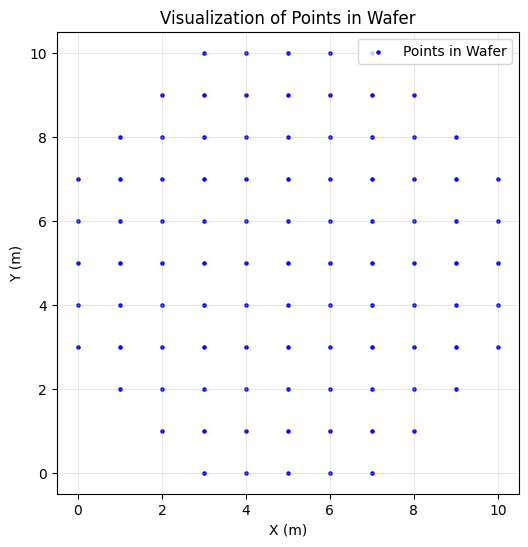

In [28]:
# Extract x and y coordinates for plotting
x_coords, y_coords = zip(*POINTS_IN_WAFER)

# Plotting the points
plt.figure(figsize=(6, 6))
plt.scatter(x_coords, y_coords, color='blue', s=5, label="Points in Wafer")
plt.gca().set_aspect('equal', adjustable='box')  # Ensure equal aspect ratio for proper circular shape
plt.title("Visualization of Points in Wafer")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [31]:
def gaussian_around_point(point):
    exp0 = 0.8
    wave_width = DX
    x_center, y_center = DX*point[0], DY*point[1]
    exp = exp0 * np.exp(-((x_coord[:, None] - x_center)**2 + (y_coord[None, :] - y_center)**2) / (2 * wave_width**2))
    return exp

In [32]:
#BOUNDARY AND INITIAL CONDITIONS
T_initial_wafer = np.zeros((Nx, Ny), dtype=np.float64)
T_initial_ag = np.zeros((Nx, Ny), dtype=np.float64)
T_initial_ted = np.zeros((Nx, Ny), dtype=np.float64)

T_initial_wafer = T_initial_wafer + T_AMBIENT
T_initial_ag = T_initial_ag + T_AMBIENT
T_initial_ted = T_initial_ted + T_BOTTOM_PLATE

#Wafer at different temperature
for point in POINTS_IN_WAFER:
    T_initial_wafer[point[0], point[1]] += 10
# perturbations
# T_initial_wafer[Nx//2 -5 : Nx//2 + 5, Ny//2 - 5:Ny//2 + 5] += 10

#Random non-uniformities
for i in range(15):
    rnd_point = random.choice(POINTS_IN_WAFER)
    T_initial_wafer += (-1)** i * gaussian_around_point(rnd_point)

#make sure points not in wafer have ambient temperature
for point in POINTS_NOT_IN_WAFER: 
    T_initial_wafer[point[0],point[1]] = T_AMBIENT

T_initial_wafer = T_initial_wafer.transpose()
T_initial_ag = T_initial_ag.transpose()
T_initial_ted = T_initial_ted.transpose()

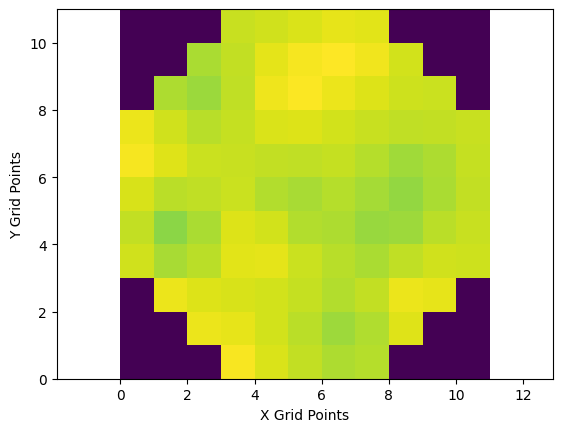

In [33]:
# Make plot of wafer cirlce
plt.pcolormesh(T_initial_wafer, shading='auto', cmap='viridis')
plt.axis('equal')  # Ensures equal aspect ratio for x and y dimensions
# plt.colorbar(label='Temperature')
plt.xlabel('X Grid Points')
plt.ylabel('Y Grid Points')
# plt.title('Initial Temperature of the Wafer')
plt.show()

In [34]:
def foward_difference(T, dx, i, j, axis, sign, material):
    #material = 0 denotes silicon, material = 1 denotes air
    #sign denotes whether the point that the temperature is compared to is before or after spatially wrt the current point
    COND_COEFF_list = [COND_COEFF_SIL, COND_COEFF_AIR]
    if sign == 1: #after
        i_prime = i + 1
        j_prime = j + 1
    elif sign == -1: #before
        i_prime = i - 1
        j_prime = j - 1
    if axis == 1:
        if [i_prime, j] in POINTS_IN_WAFER:
            return (T[i_prime, j] - T[i, j])/dx
        else:
        #simplify code by not making another line for convection on sides
            return (T_AMBIENT - T[i,j]) * CONV_COEFF_AIR * 1/COND_COEFF_list[material] 
    elif axis == 2:
        if [i, j_prime] in POINTS_IN_WAFER:
            return (T[i, j_prime] - T[i, j])/dx
        else:
            return (T_AMBIENT - T[i,j]) * CONV_COEFF_AIR * 1/COND_COEFF_list[material]

In [35]:
def pde_system(t, y):
    #Initalise arrays for tempearture, derivatives and heats
    T_wafer = np.zeros_like(T_initial_wafer, dtype=np.float64)
    dT_wfdt = np.zeros_like(T_wafer, dtype=np.float64)
    q_wf_up = np.zeros_like(T_wafer, dtype=np.float64)
    q_wf_down = np.zeros_like(T_wafer, dtype=np.float64)
    q_wf_right = np.zeros_like(T_wafer, dtype=np.float64)
    q_wf_left = np.zeros_like(T_wafer, dtype=np.float64)
    q_wf_top = np.zeros_like(T_wafer, dtype=np.float64)
    q_wf_bottom = np.zeros_like(T_wafer, dtype=np.float64)

    T_ag = np.zeros_like(T_initial_ag, dtype=np.float64)
    dT_agdt = np.zeros_like(T_ag, dtype=np.float64)
    q_ag_up = np.zeros_like(T_ag, dtype=np.float64)
    q_ag_down = np.zeros_like(T_ag, dtype=np.float64)
    q_ag_right = np.zeros_like(T_ag, dtype=np.float64)
    q_ag_left = np.zeros_like(T_ag, dtype=np.float64)
    q_ag_top = np.zeros_like(T_ag, dtype=np.float64)
    q_ag_bottom = np.zeros_like(T_ag, dtype=np.float64)

    T_ted = np.zeros_like(T_initial_ted, dtype=np.float64)
    dT_teddt = np.zeros_like(T_ted, dtype=np.float64)
    #Turn solution vector into two arrays so its easier to deal with specific points
    T_big = y.reshape(3,Nx*Ny)
    T_wafer = T_big[0].reshape(Nx,Ny)
    T_ag = T_big[1].reshape(Nx,Ny)
    T_ted = T_big[2].reshape(Nx, Ny)
    # for i in range(Nx):
    #     T_wafer[:,i] = y[Ny * i: Ny * (i+1)]
    #     T_ag[:,i] = y[Ny * (i + Nx): Ny * (i+Nx + 1)]

    for i in range(Nx):
        for j in range(Ny):
            if [i,j] in POINTS_IN_WAFER:
                #Heat PDE for points in wafer
                q_wf_up[i,j] = COND_COEFF_SIL * DX * HEIGHT_WF * foward_difference(T_wafer, DY, i, j, axis=2, sign = 1, material=0)
                q_wf_down[i,j] = COND_COEFF_SIL * DX * HEIGHT_WF * foward_difference(T_wafer, DY, i  , j, axis=2, sign = -1, material=0)
                q_wf_right[i,j] = COND_COEFF_SIL * HEIGHT_WF * DY * foward_difference(T_wafer, DX, i, j, axis=1, sign = 1 ,material=0)
                q_wf_left[i,j] = COND_COEFF_SIL * HEIGHT_WF * DY * foward_difference(T_wafer, DX, i, j, axis=1, sign = -1, material=0)
                q_wf_top [i,j] = CONV_COEFF_AIR * DX * DY * (T_AMBIENT - T_wafer[i,j])
                q_wf_bottom[i,j] = COND_COEFF_AIR * DX *DY * (T_ag[i,j] - T_wafer[i,j])/(HEIGHT_AG/2)

                dT_wfdt[i,j] = 1/(DENSITY_SIL * HEAT_CAPACITY_SIL * DX * DY * HEIGHT_WF) * ( q_wf_up[i,j] + q_wf_down[i,j] + q_wf_right[i,j] + q_wf_left[i,j] + q_wf_top[i,j] + q_wf_bottom[i,j])
                # dT_wfdt[i,j] = 1/(DENSITY_SIL * HEAT_CAPACITY_SIL) * ( q_wf_up[i,j] + q_wf_down[i,j] + q_wf_right[i,j] + q_wf_left[i,j] + q_wf_top[i,j] + q_wf_bottom[i,j])

                #Heat PDE for discretized airgap
                q_ag_up[i,j] = COND_COEFF_AIR * DX * HEIGHT_AG * foward_difference(T_ag, DY, i, j, axis=2, sign = 1, material=1)
                q_ag_down[i,j] = COND_COEFF_AIR * DX * HEIGHT_AG * foward_difference(T_ag, DY, i  , j, axis=2, sign = -1, material=1)
                q_ag_right[i,j] = COND_COEFF_AIR * HEIGHT_AG * DY * foward_difference(T_ag, DX, i, j, axis=1, sign = 1, material=1)
                q_ag_left[i,j] = COND_COEFF_AIR * HEIGHT_AG * DY * foward_difference(T_ag, DX, i, j, axis=1, sign = -1, material=1)
                q_ag_top [i,j] = COND_COEFF_SIL * DX * DY * (T_wafer[i,j] - T_ag[i,j])/(HEIGHT_AG/2)
                q_ag_bottom[i,j] = COND_COEFF_PLATE * DX *DY * (T_ted[i,j] - T_ag[i,j])/(HEIGHT_AG/2)

                dT_agdt[i,j] = 1/(DENSITY_AIR * HEAT_CAPACITY_AIR * DX * DY * HEIGHT_AG) * ( q_ag_up[i,j] + q_ag_down[i,j] + q_ag_right[i,j] + q_ag_left[i,j] + q_ag_top[i,j] + q_ag_bottom[i,j])
                # dT_agdt[i,j] = 1/(DENSITY_AIR * HEAT_CAPACITY_AIR) * ( q_ag_up[i,j] + q_ag_down[i,j] + q_ag_right[i,j] + q_ag_left[i,j] + q_ag_top[i,j] + q_ag_bottom[i,j])
            
            else: #If point not in circle, constant temperature
                dT_wfdt[i,j] = 0
                dT_agdt[i,j] = 0
                dT_teddt[i,j] = 0

    dTdt = np.array([dT_wfdt.flatten(), dT_agdt.flatten(), dT_teddt.flatten()]).flatten() #Return a derivate vector with the same dimensions as solution vec
    return dTdt

In [36]:
    # for i in range(Nx - 1):
    #     #Boundary at the bottom
    #     q_up[i,0] = COND_COEFF * DX * DY * foward_difference(T, DY, i, 0, axis=2)
    #     q_down[i,0] = COND_COEFF * DX * DY * (T[i,0] - T_AMBIENT)/DY
    #     q_right[i,0] = COND_COEFF * DX * DY * foward_difference(T, DX, i, 0, axis=1)
    #     q_left[i,0] = COND_COEFF * DX * DY * backwards_difference(T, DX, i, 0, axis=1)
    #     q_top [i,0] = CONV_COEFF * DX * DY * (T_AMBIENT - T[i,0])
    #     dTdt[i,0] = 1/(DENSITY * HEAT_CAPACITY * DX * DY * HEIGHT) * ( q_up[i,0] + q_down[i,0] + q_right[i,0] + q_left[i,0] + q_top[i,0])
    
    #     #Boundary at the top
    #     q_up[i,Ny - 1] = COND_COEFF * DX * DY * (T_AMBIENT - T[i,Ny - 1])/DY
    #     q_down[i,Ny - 1] = COND_COEFF * DX * DY * backwards_difference(T, DY, i, Ny - 1, axis=2)
    #     q_right[i,Ny - 1] = COND_COEFF * DX * DY * foward_difference(T, DX, i, Ny - 1, axis=1)
    #     q_left[i,Ny - 1] = COND_COEFF * DX * DY * backwards_difference(T, DX, i, Ny - 1, axis=1)
    #     q_top [i,Ny - 1] = CONV_COEFF * DX * DY * (T_AMBIENT - T[i,Ny - 1])        
    #     dTdt[i,Ny - 1] = 1/(DENSITY * HEAT_CAPACITY * DX * DY * HEIGHT) * ( q_up[i,Ny - 1] + q_down[i,Ny - 1] + q_right[i,Ny - 1] + q_left[i,Ny - 1] + q_top[i,Ny - 1])
        
    #     #Boundary at the left (Assuming DX = DY)
    #     q_up[0,i] = COND_COEFF * DX * DY * foward_difference(T, DY, 0, i, axis=2)
    #     q_down[0,i] = COND_COEFF * DX * DY * backwards_difference(T, DY, 0, i, axis=2)
    #     q_right[0,i] = COND_COEFF * DX * DY * foward_difference(T, DX, 0, i, axis=1)
    #     q_left[0,i] = COND_COEFF * DX * DY * (T[0,i] - T_AMBIENT)/DX
    #     q_top [0,i] = CONV_COEFF * DX * DY * (T_AMBIENT - T[0,i])


    #     #Boundary at the right (Assuming DX = DY)  
    #     q_up[Nx - 1,i] = COND_COEFF * DX * DY * foward_difference(T, DY, i, j, axis=2)
    #     q_down[Nx - 1,i] = COND_COEFF * DX * DY * backwards_difference(T, DY, i, j, axis=2)
    #     q_right[Nx - 1,i] = COND_COEFF * DX * DY * foward_difference(T, DX, i, j, axis=1)
    #     q_left[Nx - 1,0] = COND_COEFF * DX * DY * backwards_difference(T, DX, i, j, axis=1)
    #     q_top [Nx - 1,0] = CONV_COEFF * DX * DY * (T_AMBIENT - T[i,j])

In [37]:
t0 = 0
tf = Total_time
#solve_ivp only takes a vector as input for y0, hence all the two arrays are turned into a vector
y0 = np.array([T_initial_wafer.flatten(), T_initial_ag.flatten(), T_initial_ted.flatten()]).flatten()
dt = 0.1
t_eval = [dt *  i for i in range(int((tf-t0)//dt))]
sol1 = solve_ivp(pde_system, t_span=(0,tf), y0=y0, method="BDF", t_eval = t_eval)

In [38]:
def rungeKutta(y0:float, tspan:tuple, delta_t:float, ode:callable):

    t0, tend = tspan
    n = int((tend - t0)/delta_t) 

    y = [y0]
    t = [t0]

    for i in range(1, n + 1):

        k1 = delta_t * ode(t0, y[i-1])
        k2 = delta_t * ode(t0 + 0.5 * delta_t, y[i-1] + 0.5 * k1)
        k3 = delta_t * ode(t0 + 0.5 * delta_t, y[i-1] + 0.5 * k2)
        k4 = delta_t * ode(t0 + delta_t, y[i-1] + k3)
 
        # Update next value of y
        y.append(y[i-1] + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4))
 
        # Update next value of x
        t0 = t0 + delta_t
        t.append(t0)

    return t, y

In [39]:
# t0 = 0
# tf = Total_time
# y0 = np.array([T_initial_wafer.flatten(), T_initial_ag.flatten()]).flatten()
# # dt = 0.5
# # t_eval = [dt *  i for i in range(int((tf-t0)//dt))]
# t_vals, y_vals = rungeKutta(y0, tspan=(t0,tf), delta_t =0.01, ode=pde_system)

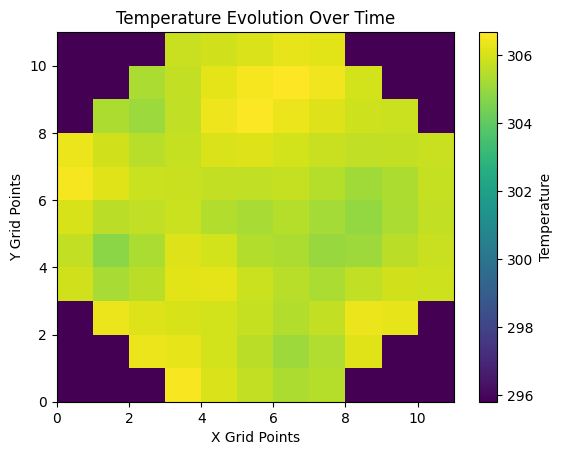

MovieWriter ffmpeg unavailable; using Pillow instead.


In [43]:
# time_steps = t_vals
# values = [y_vals[i][:Nx*Ny].reshape(Ny, Nx) for i in range(len(time_steps))]

time_steps = len(sol1.t)
values = sol1.y[:Nx*Ny].transpose()
values = values.reshape(time_steps, Ny, Nx)  # Reshape into (time_steps, Ny, Nx)

# Create the figure and axis
fig, ax = plt.subplots()
cax = ax.pcolormesh(values[0], shading='auto', cmap='viridis')  # Initial heatmap

# Add a colorbar to show the temperature scale
cbar = fig.colorbar(cax)
cbar.set_label('Temperature')

# Set up the plot title and labels
ax.set_title("Temperature Evolution Over Time")
ax.set_xlabel("X Grid Points")
ax.set_ylabel("Y Grid Points")

# Update function for the animation
def update(frame):
    cax.set_array(values[frame])  # Update the heatmap with the new time step
    ax.set_title(f"Temperature Evolution Over Time (Time: {round(t_eval[frame],2)})")
    return cax,

# Create the animation
ani = FuncAnimation(fig, update, frames=range(time_steps), blit=False, interval=100)

# Display the animation
plt.show()

# Save the animation as a GIF (optional)
ani.save('temperature_evolution_ag.gif', writer='ffmpeg', fps=10)